# Debug stats

## Initialization

In [3]:
from pymongo import MongoClient
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Parameters and all databases identification

_you can change the target database here_

In [4]:
client = MongoClient("manager-mongo-manager")
db = client["private-recsys"]
coll_names = db.list_collection_names(nameOnly=True)
print(coll_names)
#[x for x in list(db["experiments"].find())]

min_sec=0
max_sec=1200

['private-recsys.proxy50_020210808102419.locust_request_result', 'experiments']


#### Results load depending on min_sec / max_sec

In [5]:
import pprint

grp_df = None
for coll_name in coll_names:
    if coll_name != "experiments":
        #m = {"name":'"{}"'.format(coll_name)}
        m = {"name":coll_name}
        #print(m)
        xp = db["experiments"].find_one({"name":coll_name.split(".")[1]})
        if xp is None:
            continue
        #if xp["status"] != "finished":
        #    continue

        print (coll_name)

        df_recsys = pd.DataFrame.from_dict(xp["params_recsys"],orient='index').T.add_prefix("recsys_")
        df_injector = pd.DataFrame.from_dict(xp["params_injector"],orient='index').T.add_prefix("injector_")
        df_metadata = pd.concat([df_recsys, df_injector], axis=1)

        cursor = db[coll_name].find()
        entries = list(cursor)
        
        df = pd.DataFrame(entries)
        df=pd.concat([df, pd.concat([df_metadata]*len(df), ignore_index=True)], axis=1)

        db["experiments"].find_one_and_update({"_id":xp["_id"]}, 
                                               {"$set": {"results.response_time_mean":df["response_time"].mean(),
                                                         "results.quantity":len(df)
                                                        }
                                               }
                                               )        
        df["dt"] = pd.to_datetime(df['start'], unit="ms")
        df = df.dropna(subset=['dt'])
        df["dt_end"] = df["dt"]+ pd.to_timedelta(df["response_time"], unit="ms")
        df["relative_time"] = (df["dt"] - min(df["dt"])).astype("timedelta64[ms]")
        df["relative_time_seconds"] = (df["relative_time"] // 1000).astype(int)
        df["relative_end_time"] = (df["dt_end"] - min(df["dt"])).astype("timedelta64[ms]")
        df["relative_end_time_seconds"] = (df["relative_end_time"] // 1000).astype(int)
        
        if grp_df is None:
            grp_df = df[(df["relative_time_seconds"] >= min_sec) & ((df["relative_time_seconds"] <= max_sec))]
        else:
            grp_df = pd.concat([grp_df, df[(df["relative_time_seconds"] >= min_sec)&(df["relative_time_seconds"] >= min_sec)]])
        #plt.title("{}-{}-{}".format(xp["name"], xp["params_injector"]["clients"], xp["params_recsys"]["mongo!replicaSet!replicas!secondary"]))
        #plt.figure()
     


private-recsys.proxy50_020210808102419.locust_request_result


In [6]:
grp_df.dtypes

_id                                          object
response_time                               float64
response_length                              object
http_status                                   int64
content                                      object
start                                       float64
dt                                   datetime64[ns]
exception                                    object
payload                                      object
url                                          object
time                                 datetime64[ns]
recsys_hostAddress                           object
recsys_harness!replicaCount                  object
recsys_proxy-sgx!replicaCount                object
recsys_proxy-sgx!proxyType1                  object
recsys_proxy-sgx!proxyType2                  object
recsys_proxy-sgx!targetPort                  object
recsys_proxy-sgx!enableEncryption            object
recsys_proxy-sgx!bufferShuffling             object
recsys_proxy

## Violin response time vs concurrency/targetHost/encryption

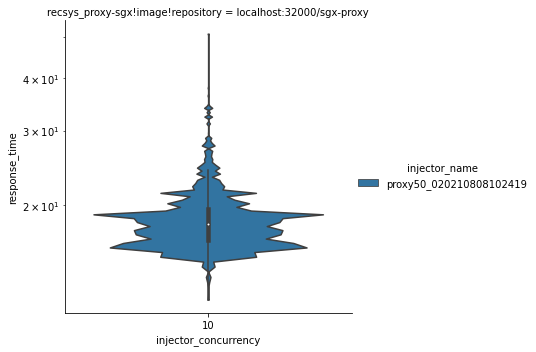

In [7]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.75)

import numpy as np
#grp_df_one = grp_df[grp_df["relative_time_seconds"] >= 300]
d = grp_df.groupby(["injector_clients", "injector_targetHost", "recsys_proxy-sgx!enableEncryption", "injector_name"]).agg(
    mean_response_time=pd.NamedAgg(column='response_time', aggfunc="mean"),
    #q1=pd.NamedAgg(column='response_time', aggfunc=lambda x:(q1(x))),
    median_response_time=pd.NamedAgg(column='response_time', aggfunc="median"),
    #q3=pd.NamedAgg(column='response_time', aggfunc=lambda x:(q3(x))),
    duration=pd.NamedAgg(column="relative_end_time_seconds", aggfunc=lambda x:(len(x.unique()))),
    count=pd.NamedAgg(column="_id", aggfunc=lambda x:(len(x)))
    )
grp = d.reset_index()
#fig,ax = plt.subplots()

q = sns.catplot(kind="violin", x="injector_concurrency", y="response_time", col="recsys_proxy-sgx!image!repository", hue="injector_name", data=grp_df, bw=.001)
q.set(yscale="log")

## General stats

In [8]:
grp["tp"]= grp["count"]/grp["duration"]
grp

,injector_clients,injector_targetHost,recsys_proxy-sgx!enableEncryption,injector_name,mean_response_time,median_response_time,duration,count,tp
0,50,http://stub-proxy-sgx-1:8080,1,proxy50_020210808102419,18.588949,18.03846,301,14999,49.830565


In [9]:
percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]
grp_df[(grp_df.relative_time_seconds > 270) & (grp_df.relative_time_seconds < 300)].groupby(["injector_clients","injector_name"])["response_time"].describe(percentiles=percentiles)

,,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
injector_clients,injector_name,,,,,,,,,,,,
50,proxy50_020210808102419,1451.0,18.402619,3.055127,12.215308,16.374347,17.908255,19.414497,21.969538,23.941037,29.359663,38.3791,45.49934


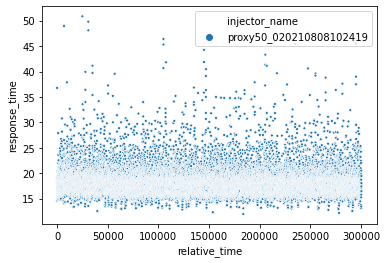

In [10]:
sns.scatterplot(data=grp_df, x="relative_time", y="response_time", hue="injector_name",marker=".") 

proxy50_020210808102419


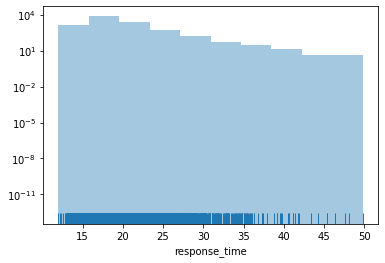

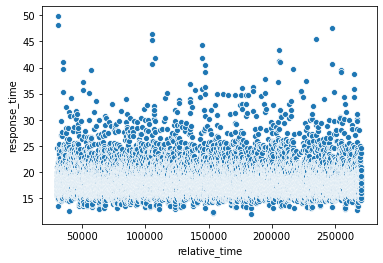

In [11]:
for name in grp_df.injector_name.unique():
    xp_df = grp_df[(grp_df.injector_name == name)&(grp_df.relative_time_seconds >=30) & (grp_df.relative_time_seconds <=270)]
    print(name)
    plt.figure()
    splot = sns.distplot(xp_df["response_time"],bins=10, kde=False, rug=True)
    splot.set(yscale="log")
    plt.figure()
    sns.scatterplot(data=xp_df[xp_df.relative_time >0], x="relative_time", y="response_time")    
    


## Response time and TP vs start or end request (by experiment)

proxy50_020210808102419


/opt/conda/lib/python3.8/site-packages/seaborn/relational.py:818: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/conda/lib/python3.8/site-packages/seaborn/relational.py:829: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
/opt/conda/lib/python3.8/site-packages/seaborn/relational.py:818: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/conda/lib/python3.8/site-packages/seaborn/relational.py:829: MatplotlibDeprecationWarning: Saw kwargs ['c', 'col

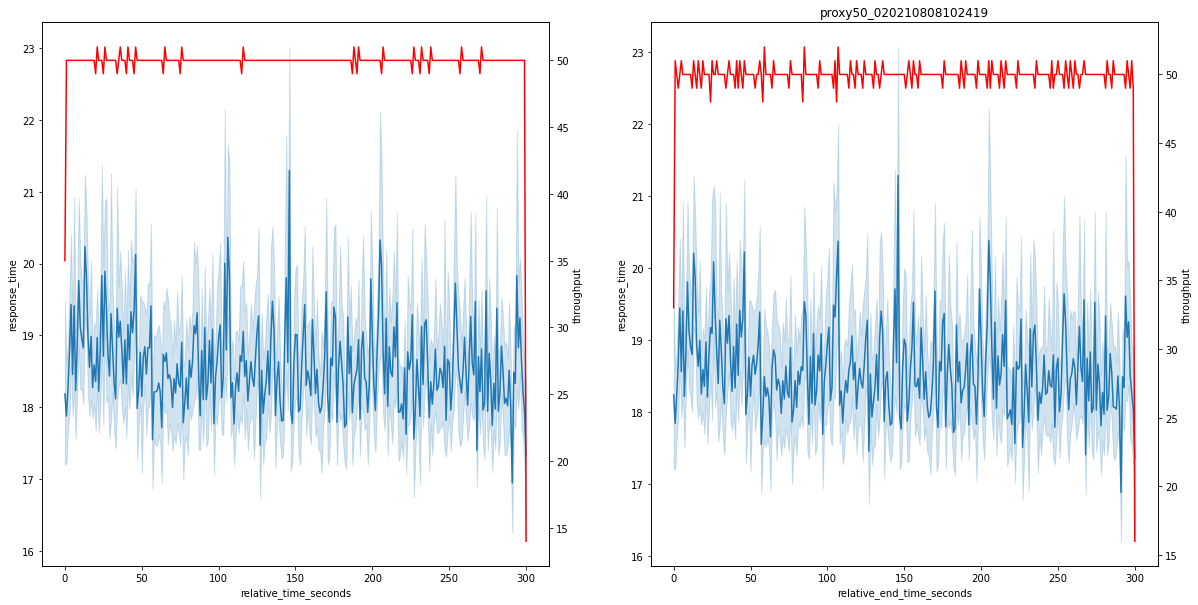

In [13]:
plt.rcParams["figure.figsize"] = (20,10)
for name in grp_df["injector_name"].unique():
#plop = grp_df[grp_df["injector_name"]==name].groupby("relative_time_seconds")["_id"].count().reset_index(name='throughput')
    print(name)
    df_xp = grp_df[grp_df["injector_name"] == name]
    #start_time = df_xp["injector_start_time"].unique()[0]
    #end_time = df_xp["injector_end_time"].unique()[0]    
    fig, ax = plt.subplots(1,2)
    plt.title(name)

    sns.lineplot(x="relative_time_seconds", y="response_time", data=grp_df[grp_df["injector_name"]==name], ax=ax[0])
    ax2 = ax[0].twinx()
    
    df_tp = grp_df[grp_df["injector_name"]==name].groupby("relative_time_seconds")["_id"].count().reset_index(name='throughput')
    sns.lineplot(x="relative_time_seconds", y="throughput", data=df_tp, ax=ax2, c="r")

    sns.lineplot(x="relative_end_time_seconds", y="response_time", data=grp_df[grp_df["injector_name"]==name], ax=ax[1])
    ax2 = ax[1].twinx()
    
    df_tp = grp_df[grp_df["injector_name"]==name].groupby("relative_end_time_seconds")["_id"].count().reset_index(name='throughput')
    sns.lineplot(x="relative_end_time_seconds", y="throughput", data=df_tp, ax=ax2, c="r")
    break